### The goal is to make a multi-class classification model to assess if deep and superficial cells modulate their firing rates in the same way to encode context.

Each unit will have an accuracy score how how well it can encode different back to back environments.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)
import nelpy as nel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## locate sessions with many back to back mazes that are different from each other



In [4]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

epoch_df = pd.DataFrame()
for basepath in df.basepath:
    epochs = loading.load_epoch(basepath)
    epochs['basepath'] = basepath
    epoch_df = pd.concat([epoch_df, epochs], ignore_index=True)

epoch_df = epoch_df[epoch_df.environment != "sleep"]

for basepath in epoch_df.basepath.unique():
    epoch_df.loc[epoch_df.basepath == basepath,"n_unique"] = epoch_df[epoch_df.basepath == basepath].environment.nunique()

sessions_df = pd.DataFrame()
sessions_df["basepath"] = epoch_df[epoch_df.n_unique > 1].basepath.unique()
sessions_df.head()

,basepath
0,Z:\Data\AYAold\AB3\AB3_38_41
1,Z:\Data\AYAold\AB3\AB3_42_46
2,Z:\Data\AYAold\AYA7\day25
3,Z:\Data\AYAold\AYA9\day12
4,Z:\Data\GirardeauG\Rat08\Rat08-20130710


In [34]:
for basepath in epoch_df[epoch_df.n_unique > 1].basepath.unique():
    print(basepath, epoch_df[epoch_df.basepath == basepath].environment.unique())


Z:\Data\AYAold\AB3\AB3_38_41 ['tmaze' 'linear']
Z:\Data\AYAold\AB3\AB3_42_46 ['tmaze' 'linear']
Z:\Data\AYAold\AYA7\day25 ['cheeseboard' 'box']
Z:\Data\AYAold\AYA9\day12 ['linear' 'box']
Z:\Data\GirardeauG\Rat08\Rat08-20130710 ['linear' 'water']
Z:\Data\GirardeauG\Rat10\Rat10-20140619 ['linear' 'unknown']
Z:\Data\Kenji\2006-4-10 ['linear' 'open']
Z:\Data\Kenji\2006-4-18 ['linear' 'open' 'tmaze']
Z:\Data\Kenji\2006-6-12 ['linearOne' 'linearTwo' 'Tmaze']
Z:\Data\Kenji\2006-6-13 ['linearOne' 'linearTwo' 'wheel' 'Tmaze']
Z:\Data\Kenji\2006-6-7 ['linearOne' 'linearTwo']
Z:\Data\Kenji\ec013.152_157 ['bigSquare' 'linear']
Z:\Data\Kenji\ec013.194_213 ['bigSquare' 'linear']
Z:\Data\Kenji\ec013.242_258 ['bigSquare' 'linear']
Z:\Data\Kenji\ec013.370_390 ['linear' 'wheel' 'bigSquare']
Z:\Data\Kenji\ec013.393_418 ['linear' 'wheel' 'bigSquare']
Z:\Data\Kenji\ec013.421_447 ['Mwheel' 'wheel' 'bigSquare' 'linear']
Z:\Data\Kenji\ec013.451_470 ['linear' 'bigSquare' 'wheel']
Z:\Data\Kenji\ec013.480_509 ['

In [6]:
basepath = r"Z:\Data\Kenji\ec013.702_724"
# get behavioral epochs
epoch_df = loading.load_epoch(basepath)
# remove sleep epochs
epoch_df = epoch_df[epoch_df.environment != "sleep"]
# remove epochs that were too short
epoch_df = epoch_df[((epoch_df.stopTime - epoch_df.startTime) / 60) > 5]
epochs = nel.EpochArray(
            [np.array([epoch_df.startTime, epoch_df.stopTime]).T],
            label=epoch_df.environment.values,
        )
# load spikes
spikes,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")
display(epoch_df)
spikes,epochs

,name,startTime,stopTime,environment,behavioralParadigm
3,ec013.705_Mwheel,6404.8934,8605.2644,Mwheel,10
11,ec013.713_bigSquare,18187.2406,20457.6536,bigSquare,10
12,ec013.714_bigSquare,20457.6536,22735.7536,bigSquare,10
13,ec013.715_wheel,22735.7536,23680.2912,wheel,10
14,ec013.717_wheel,23680.2912,24799.3182,wheel,10
15,ec013.718_linear,24799.3182,25989.2062,linear,10
16,ec013.719_linear,25989.2062,27191.3822,linear,10
17,ec013.720_linear,27191.3822,28570.9152,linear,10


(<SpikeTrainArray at 0x2140b3089a0: 22 units> at 20000 Hz,
 <EpochArray at 0x2147dc01c70: 8 epochs> of length 3:29:44:045 hours)

<AxesSubplot:>

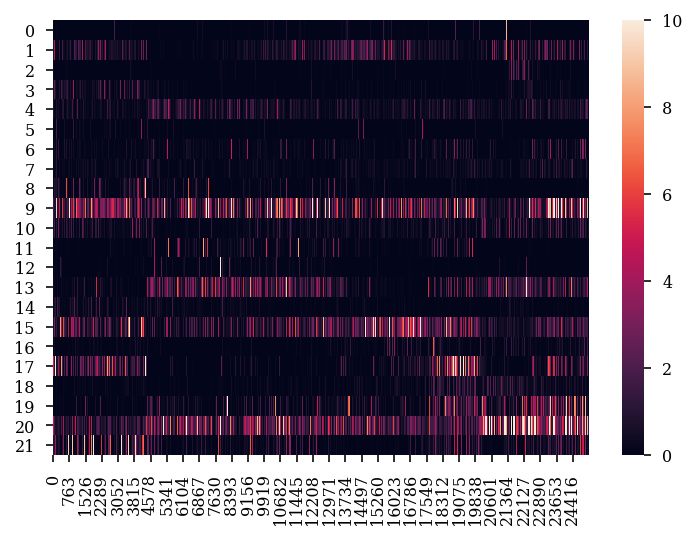

In [54]:
sns.heatmap(bst.data,vmax=10)

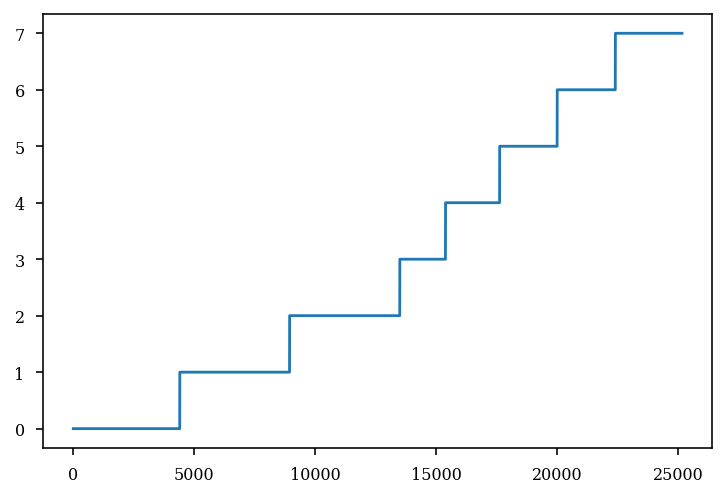

In [53]:
bst = spikes[epochs].bin(ds=0.5).smooth(sigma=1)
y = np.hstack([np.zeros(bst_.n_bins) + i_epoch for i_epoch,bst_ in enumerate(bst)])

plt.plot(y)
plt.show()

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = bst.data.T

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [87]:
from sklearn.tree import ExtraTreeClassifier # as accurate as decision tree, but faster
clf = make_pipeline(StandardScaler(), ExtraTreeClassifier())

scores = []
y_pred = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    y_pred.append(clf.predict(X_test[:,i].reshape(-1, 1)))
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
# np.mean(scores), np.std(scores)

<AxesSubplot:>

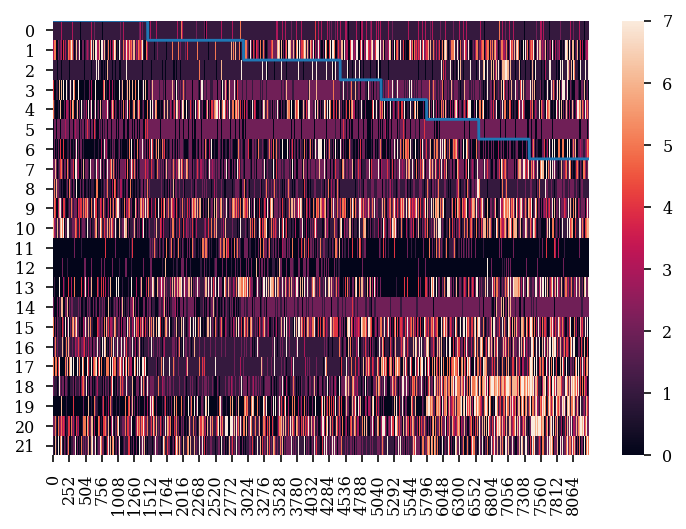

In [97]:
plt.plot(y_test[np.argsort(y_test)])
sns.heatmap(np.vstack(y_pred)[:,np.argsort(y_test)],cmap="Paired")

In [99]:
from sklearn.neural_network import MLPClassifier
clf = make_pipeline(StandardScaler(), MLPClassifier())

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.


In [85]:
from sklearn.tree import ExtraTreeClassifier # as accurate as decision tree, but faster
clf = make_pipeline(StandardScaler(), ExtraTreeClassifier())

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)

(0.22970828088227246, 0.040157622424348186)

In [86]:
from sklearn.tree import DecisionTreeClassifier

clf = make_pipeline(StandardScaler(), DecisionTreeClassifier())

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)


(0.22941820371079855, 0.03948041813172707)

In [80]:
from sklearn.linear_model import RidgeClassifier
clf = make_pipeline(StandardScaler(), RidgeClassifier())

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)

(0.2283235728750479, 0.029094709509172575)

In [84]:
from sklearn.linear_model import RidgeClassifierCV
clf = make_pipeline(StandardScaler(), RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]))

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)

(0.2283235728750479, 0.029094709509172575)

In [75]:
from sklearn.naive_bayes import BernoulliNB # lower accuracy, but lower std

clf = make_pipeline(StandardScaler(), BernoulliNB())

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)


(0.22767226752777622, 0.02848345962885675)

In [77]:
from sklearn.naive_bayes import GaussianNB # lower accuracy
clf = make_pipeline(StandardScaler(), GaussianNB())

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)

(0.202971922719063, 0.05104997269204507)

In [78]:
from sklearn.ensemble import RandomForestClassifier # similar to a decision tree, but slower
clf = make_pipeline(StandardScaler(), RandomForestClassifier())

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)

(0.2278747742323901, 0.03913784740939862)

In [58]:
from sklearn.ensemble import ExtraTreesClassifier # too slow and as accurate as DecisionTreeClassifier

# clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf = make_pipeline(StandardScaler(), ExtraTreesClassifier())

scores = []
for i in range(X_train.shape[1]):
    clf.fit(X_train[:,i].reshape(-1, 1), y_train)
    scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
np.mean(scores), np.std(scores)


(0.22971375403645122, 0.03998298861071609)

In [ ]:
# from sklearn.gaussian_process import GaussianProcessClassifier # too slow

# clf = make_pipeline(StandardScaler(), GaussianProcessClassifier(multi_class = "one_vs_one"))

# scores = []
# for i in range(X_train.shape[1]):
#     clf.fit(X_train[:,i].reshape(-1, 1), y_train)
#     scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
# np.mean(scores), np.std(scores)

In [43]:
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# scores = []
# for i in range(X_train.shape[1]):
#     clf.fit(X_train[:,i].reshape(-1, 1), y_train)
#     scores.append(clf.score(X_test[:,i].reshape(-1, 1), y_test))
# scores

[0.1802528597230584,
 0.24166164960866948,
 0.19289584587597833,
 0.23491872366044553,
 0.20891029500301023,
 0.19000602046959664,
 0.18868151715833836,
 0.1962673088500903,
 0.2054184226369657,
 0.20457555689343768,
 0.21324503311258278,
 0.2003612281757977,
 0.1892835641180012,
 0.2636965683323299,
 0.20228777844671886,
 0.20915111378687537,
 0.1950632149307646,
 0.2586393738711619,
 0.2107164358819988,
 0.21625526791089705,
 0.22576760987357014,
 0.20830824804334738]

In [42]:
# from sklearn.neighbors import KNeighborsClassifier
# # neigh = KNeighborsClassifier(n_neighbors=3)
# clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
# clf.fit(X_train[:,1].reshape(-1, 1), y_train)
# clf.score(X_test[:,1].reshape(-1, 1), y_test)



0.11992775436484046